---
title: SuchTree, with working examples
subtitle: Worked examples illustrating some basic applications of SuchTree. This file is available as a Jupyter Notebook in the project repository under docs/examples.
icon: material/notebook-outline
---

# SuchTree

and python packages :

* `SuchTree`
* `pandas`
* `cython`
* `scipy`
* `numpy`
* `matplotlib`
* `seaborn`
* `fastcluster`
* `dendropy`

and obviously you'll want `jupyter` installed so you can run the notebook server. The
Internet is full of opinions about how to set up your python environment. You
should find one that works for you, but [this guide is as good as any](https://medium.com/@henriquebastos/the-definitive-guide-to-setup-my-python-workspace-628d68552e14) to get you started.

I'm going to start off by loading the required packages and suppressing some warnings
that [should be fixed](https://github.com/mwaskom/seaborn/issues/1392) in the next
stable release of `seaborn`.

I'm going to assume that you are running this notebook out of a local copy of the 
[SuchTree repository](https://github.com/ryneches/SuchTree/) for any local file paths.

In [1]:
%config InlineBackend.figure_format='retina'

from SuchTree import SuchTree, SuchLinkedTrees
from numpy import zeros, array
import seaborn
import pandas
import toytree
import random
import warnings

from scipy.cluster.hierarchy import ClusterWarning

warnings.simplefilter( 'ignore', UserWarning )
warnings.simplefilter( 'ignore', FutureWarning )

Let's have a look at some example data. Here is a tree of cichlid fishes
from my dissertation :

In [2]:
tree = toytree.tree( '../../data/bigtrees/host.tree' )

canvas, axes, mark = tree.draw( tree_style='d', tip_labels_align=True )

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="539.152px" height="331.84px" viewBox="0 0 539.152 331.84" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tbab3d4d8a6fd49ba9ae8404e6c554a95"> Tropheus_moorii Lobochilotes_labiatus Tanganicodus_irsacae Cyprichromis_coloratus Haplotaxodon_microlepis Perissodus_microlepis Plecodus_straeleni Xenotilapia_flavipinnis Triglachromis_otostigma Reganochromis_calliurus Trematochromis_benthicola Lepidiolamprologus_profundicola Neolamprologus_buescheri Chalinochromis_brichardi

Loading tree data into `SuchTree` is pretty simple -- just give it a path
to a valid Newick file.

In [3]:
T = SuchTree( '../../data/bigtrees/host.tree' )

The `SuchTree` object has a dictionary called `leaves` that maps leaf names onto their
node ids. We'll make extensive use of this as we put the utility through its paces.

In [4]:
T.leaves

{'Tropheus_moorii': 0,
 'Lobochilotes_labiatus': 2,
 'Tanganicodus_irsacae': 4,
 'Cyprichromis_coloratus': 6,
 'Haplotaxodon_microlepis': 8,
 'Perissodus_microlepis': 10,
 'Plecodus_straeleni': 12,
 'Xenotilapia_flavipinnis': 14,
 'Triglachromis_otostigma': 16,
 'Reganochromis_calliurus': 18,
 'Trematochromis_benthicola': 20,
 'Lepidiolamprologus_profundicola': 22,
 'Neolamprologus_buescheri': 24,
 'Chalinochromis_brichardi': 26}

### Calculating distances

`SuchTree` has two ways to calculate distances; one pair a time, or
in batches. Batches are more efficient because it does each calculation without 
the interpreter's overhead.

Here's how to measure distances one at a time :

In [5]:
a = random.choice( list( T.leafs.values() ) )
b = random.choice( list( T.leafs.values() ) )

d = T.distance( a, b )

print( 'taxon 1  : %d' % a )
print( 'taxon 2  : %d' % b )
print( 'distance : %f' % d )

taxon 1  : 12
taxon 2  : 26
distance : 0.388425


The `distance()` function will accept either node ids (which are integers),
or taxon names (which are strings).

In [6]:
a = random.choice( list( T.leafs.keys() ) )
b = random.choice( list( T.leafs.keys() ) )

d = T.distance( a, b )

print( 'taxon 1  : %s' % a )
print( 'taxon 2  : %s' % b )
print( 'distance : %f' % d )

taxon 1  : Reganochromis_calliurus
taxon 2  : Haplotaxodon_microlepis
distance : 0.270743


You can loop over all of the distances one at a time to construct a distance matrix...

In [7]:
D1 = zeros( ( len(T.leaves),len(T.leaves) ) )
for i,a in enumerate(  T.leafs.values() ) :
    for j,b in enumerate( T.leafs.values() ) :
        D1[i,j] = T.distance( a, b )

Let's look at the distance matrix using a nice `seaborn` clustermap plot.

It's worth noting that `seaborn` is using scipy's `cluster.hierarchy` functions to build
those dendrograms from the distance matrix. They aren't going to have exactly the same
topology as the input tree, which was build with [RAxML](https://github.com/stamatak/standard-RAxML).

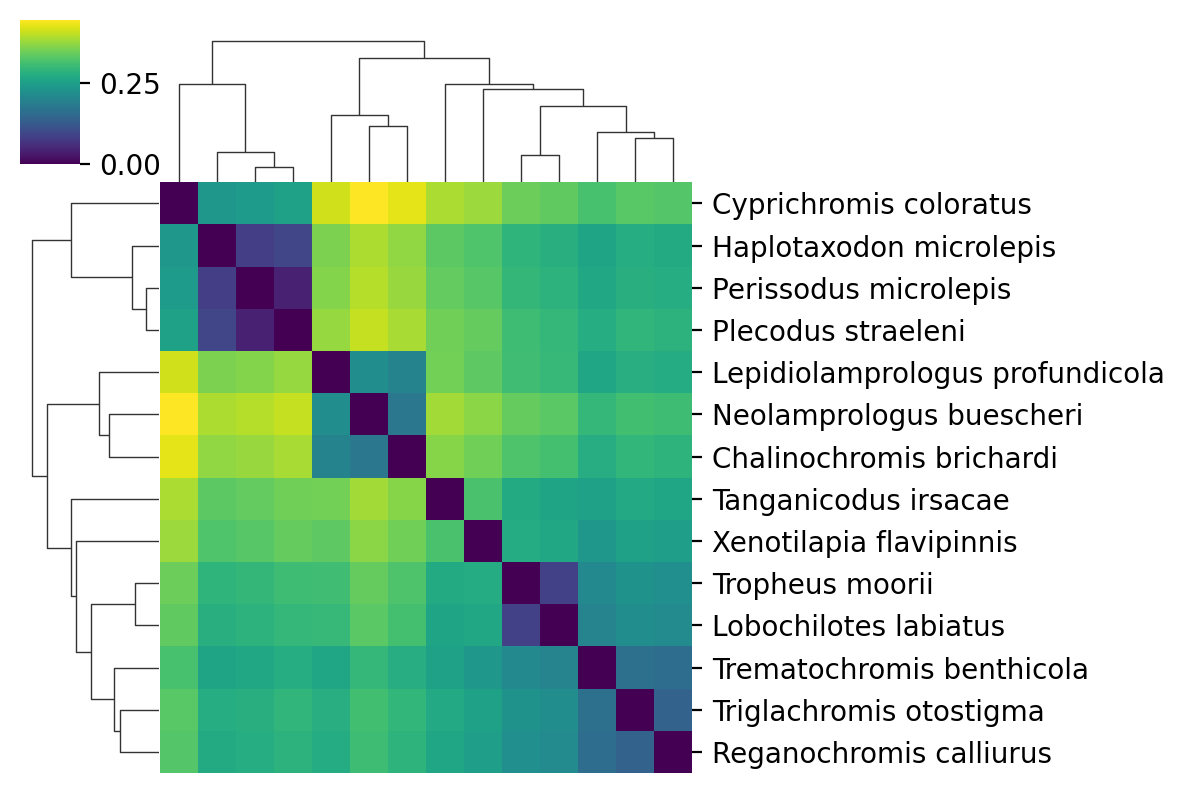

In [8]:
df = pandas.DataFrame( D1, index=[ i.replace('_',' ') for i in T.leaves.keys() ] )
seaborn.clustermap( df, xticklabels=False, cmap='viridis', figsize=(6,4) )

To calculate the distances in a batch, we can use the `distances()` function,
which takes an $n \times 2$ array of node ids (make sure your array is representing
them as integers).

In [9]:
D2_list = []
for i,a in enumerate(T.leaves.values()) :
    for j,b in enumerate( T.leaves.values() ) :
        D2_list.append( ( a, b ) )
D2_array = array( D2_list )

print( D2_array.shape )
print( D2_array[:5] )

(196, 2)
[[0 0]
 [0 2]
 [0 4]
 [0 6]
 [0 8]]


In [10]:
D2 = T.distances( D2_array )

D2 = D2.reshape( ( len(T.leafs), len(T.leafs) ) )

We should get the same distance matrix and clustermap as before.

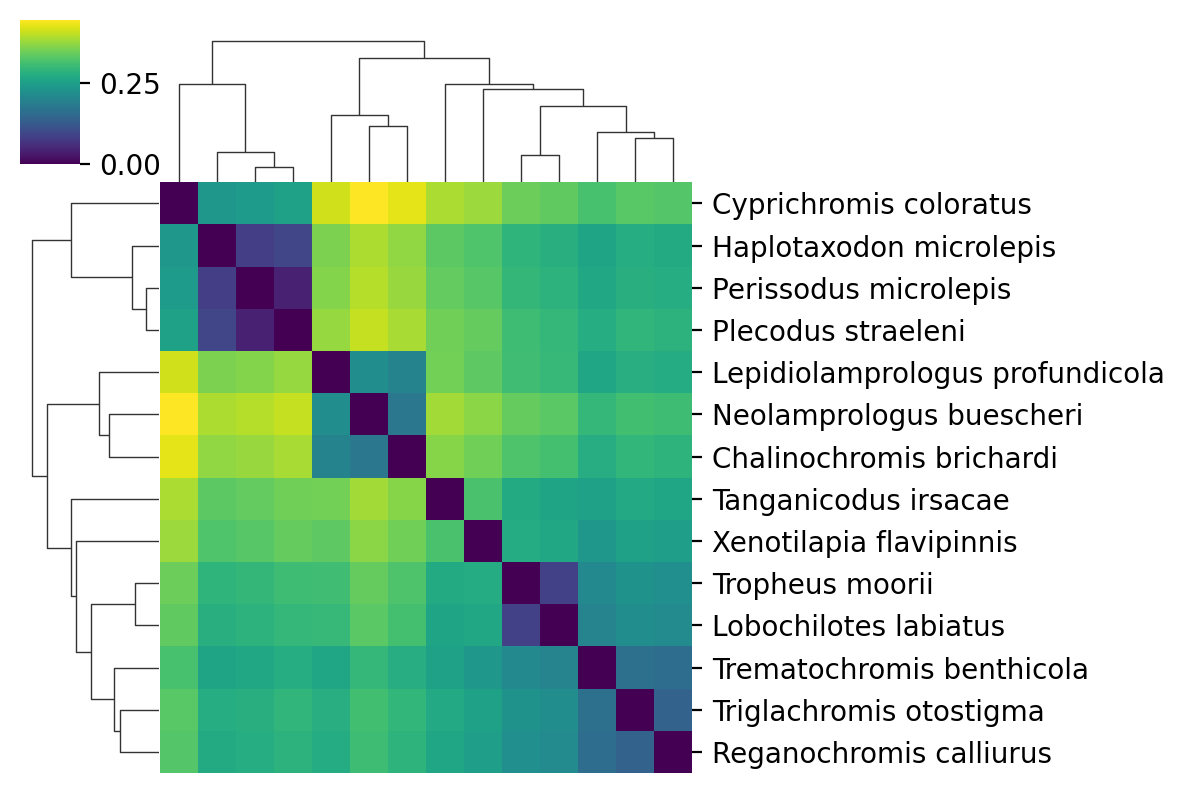

In [11]:
df = pandas.DataFrame( D2, index=[ i.replace('_',' ') for i in T.leaves.keys() ] )
seaborn.clustermap( df, xticklabels=False, cmap='viridis', figsize=(6,4) )

If you want to use taxon names instead, `distances_by_name()` accepts an $n \times 2$ list
of tuples of taxon names, and looks up the node ids for you.

### Loading data from URLs

SuchTree can also import data from the internets. Here is the distance matrix for 
the penguins, from the [Global Phylogeny of Birds](http://birdtree.org/).

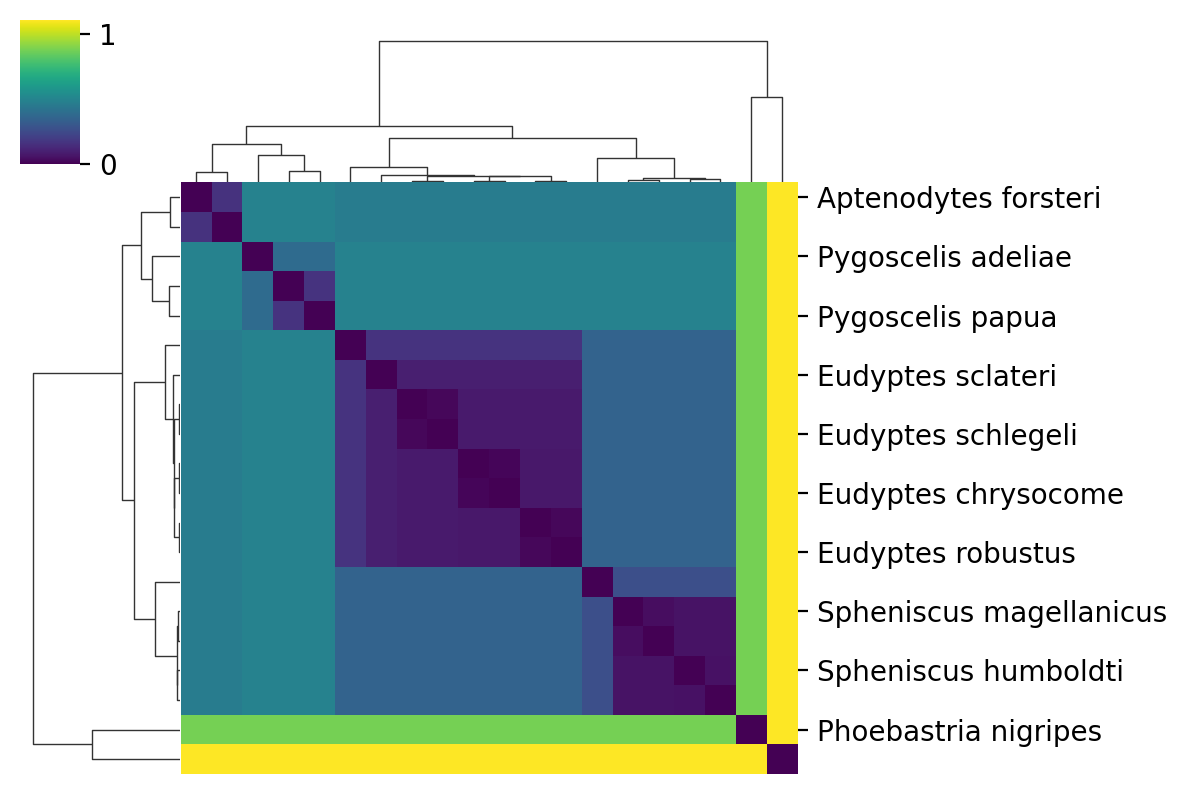

In [13]:
T3 = SuchTree( 'https://data.vertlife.org/birdtree/PatchClade/Stage2/set10/Spheniscidae.tre' )

D3_list = []
for i,a in enumerate(T3.leafs.values()) :
    for j,b in enumerate( T3.leafs.values() ) :
        D3_list.append( ( a, b ) )
D3_array = array( D3_list )
D3 = T3.distances( D3_array )
D3 = D3.reshape( ( len(T3.leafs), len(T3.leafs) ) )

df = pandas.DataFrame( D3, index=[ i.replace('_',' ') for i in T3.leafs.keys() ] )
seaborn.clustermap( df, xticklabels=False, cmap='viridis', figsize=(6,4) )

### Comparing the topologies of two large trees

So far, we haven't done anything you couldn't do with other phylogenetics packages. 
`SuchTree` really shines when you have to do a lot of distance calculations on very
large trees.

Here, we use `SuchTree` to compare the topology of a two trees containing the taxa
but constructed with different methods ([`FastTree`](http://www.microbesonline.org/fasttree/) and 
[`neighbor joining`](https://en.wikipedia.org/wiki/Neighbor_joining)). One million random pairs are 
sampled from each tree, and the distances compared.

In [21]:
T1 = SuchTree( 'https://raw.githubusercontent.com/ryneches/SuchTree/refs/heads/main/data/bigtrees/ml.tree' )
T2 = SuchTree( 'https://raw.githubusercontent.com/ryneches/SuchTree/refs/heads/main/data/bigtrees/nj.tree' )

print( 'nodes : %d, leafs : %d' % ( T1.length, len(T1.leafs) ) )
print( 'nodes : %d, leafs : %d' % ( T2.length, len(T2.leafs) ) )

nodes : 108653, leafs : 54327
nodes : 108653, leafs : 54327


In [22]:
N = 1000000

v = list( T1.leafs.keys() )

pairs = []
for i in range(N) :
    pairs.append( ( random.choice( v ), random.choice( v ) ) )
    
%time D1, D2 = T1.distances_by_name( pairs ), T2.distances_by_name( pairs )

CPU times: user 34.4 s, sys: 142 ms, total: 34.6 s
Wall time: 34.4 s


The `distances()` function, which uses node ids rather than taxa names,
would be a little bit faster. However, because the trees have different topologies,
the taxa have different node ids in each tree. `SuchTree`'s `distances_by_name()`
function untangles the leaf name to leaf node id mappings for you.

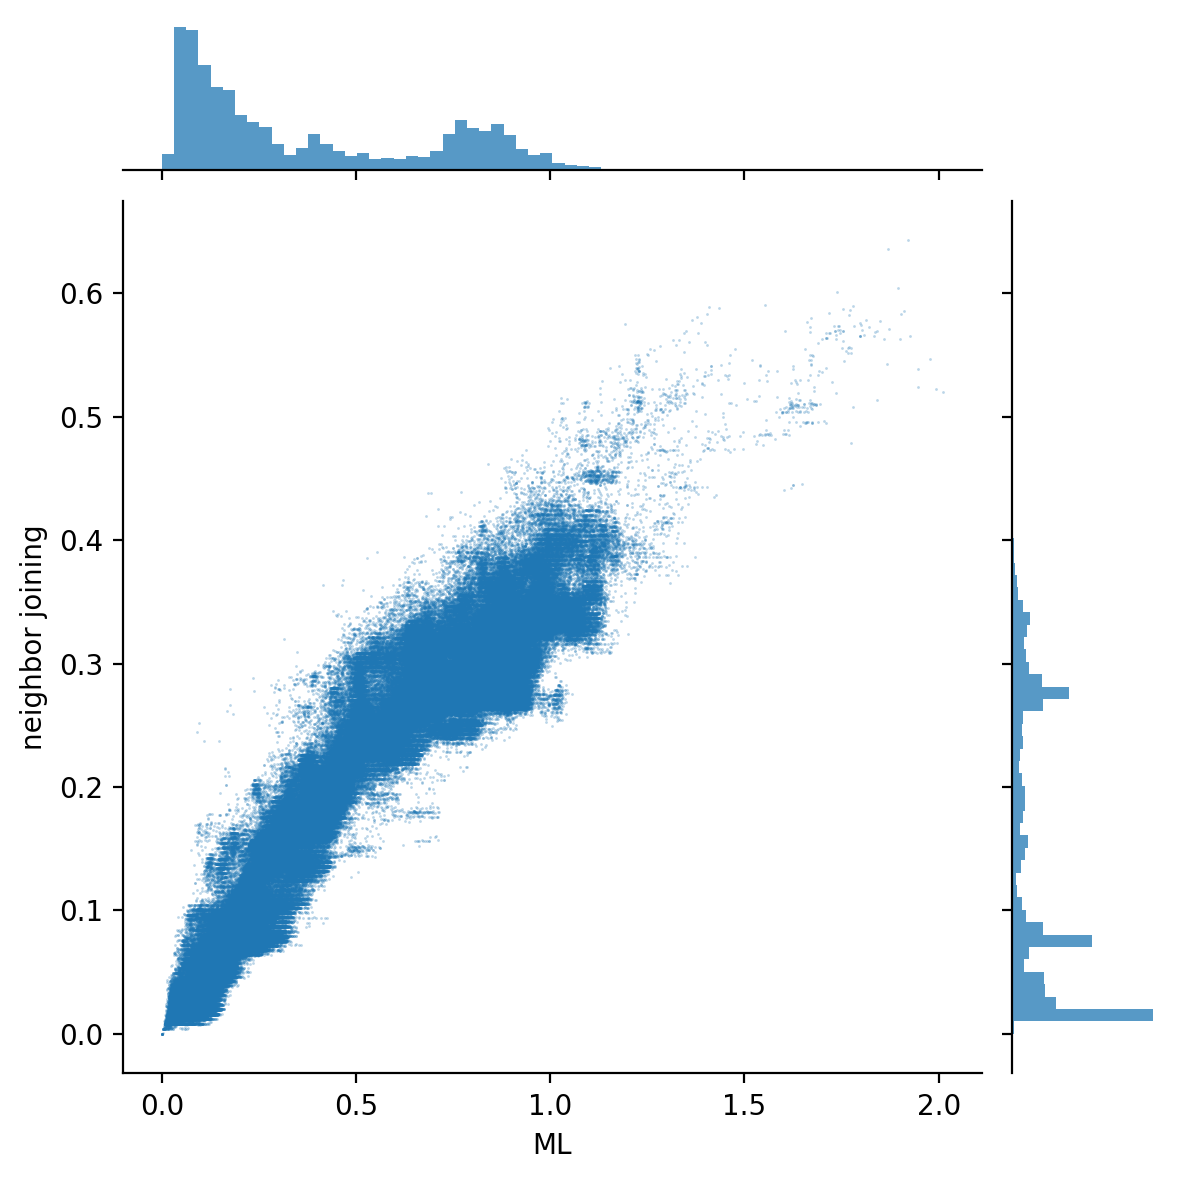

In [38]:
df = pandas.DataFrame( { 'ML' : D1, 'neighbor joining' : D2 } )

g = seaborn.jointplot( x='ML', y='neighbor joining', data=df,
                       alpha=0.3, linewidth=0, s=1,
                       marginal_kws={ 'bins': 64, 'linewidth' : 0 } )

g.ax_joint.set_xticks( [ 0, 0.5, 1.0, 1.5, 2.0 ] )

In [37]:
from scipy.stats import spearmanr, kendalltau, pearsonr

print( 'Spearman\'s rs : %0.3f' % spearmanr(  D1, D2 )[0] )
print( 'Kendall\'s tau : %0.3f' % kendalltau( D1, D2 )[0] )
print( 'Pearson\'s r   : %0.3f' % pearsonr(   D1, D2 )[0] )

Spearman's rs : 0.961
Kendall's tau : 0.824
Pearson's r   : 0.969


### Parallel processing with SuchTree

Another advantage of `SuchTree`'s support for performing batches of distance 
calculations is that these calculations can run outside of Python's 
[global interpreter lock](https://lbolla.info/blog/2013/12/23/python-threads-cython-gil).
This makes it possible to parallelize with Python's [`Threads`](https://docs.python.org/2/library/threading.html)
or [`multiprocessing`](https://docs.python.org/2/library/multiprocessing.html) libraries. On 
most Unix-like operating systems, `multiprocessing.Pool` uses a
copy-on-write scheme for data shared by jobs. Internally, SuchTree stores tree topology
data as an immutable block of memory, so no copying will take place.

For better or worse, Python gives users a lot of different strategies for parallel processing.
SuchTree is designed to work seamlessly with all of them.

| Approach | Parallelism | Memory | Overhead | Best for |
|----------|-------------|---------|----------|----------|
| Threading | No (GIL) | Shared | Low | I/O bound |
| ProcessPoolExecutor | Yes | Copied | High (pickle) | Small data |
| **Pool with fork** | **Yes** | **Shared (CoW)** | **Minimal** | **Immutable data** |
| Pool with spawn | Yes | Copied | High (pickle) | Windows |

`SuchTree` intentionally does not allow the user to alter trees once they are created,
and so distance calculations are always thread safe. This makes it possible to use only 
*one* instance of a tree for all threads (or processes or subinterpreters or whatever
parallel processing scheme you choose). This gives you best chance of keeping the data
within the CPU's L3 cache for maximum performance.

First, let's create a Cython function that calls `SuchTree` outside of the GIL.

In [39]:
%load_ext Cython

In [44]:
%%cython
import cython
from libc.math cimport sqrt

def correlation(double[:] x, double[:] y) :
    if x.shape[0] != y.shape[0] :
        raise ValueError( 'Arrays must have the same length' )
    if x.shape[0] < 2 :
        raise ValueError( 'Arrays must have at least 2 elements' )
    return _correlation( x, y )

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cdef double _correlation( double[:] x, double[:] y ) nogil :
    cdef int n = x.shape[0]
    cdef int i
    cdef double r = 0.0
    cdef double xbar = 0.0
    cdef double ybar = 0.0
    cdef double sx = 0.0
    cdef double sy = 0.0
    cdef double dx, dy
    
    # Compute means
    for i in range(n):
        xbar += x[i]
        ybar += y[i]
    xbar /= n
    ybar /= n
    
    # Compute standard deviations and correlation in one pass
    for i in range(n):
        dx = x[i] - xbar
        dy = y[i] - ybar
        sx += dx * dx
        sy += dy * dy
        r += dx * dy
        
    sx = sqrt(sx)
    sy = sqrt(sy)
    
    # Handle zero variance case
    if sx == 0.0 or sy == 0.0:
        return 0.0
    
    return r / (sx * sy)

Next, we'll load use `Pool.map()` from Python's `multiprocessing` library to run our processes in parallel.

In [48]:
from multiprocessing import Pool

n = 4   # number of processes
m = 12  # number of work units
v = list( T1.leaves.keys() )


def worker_task( args ) :
    block_idx, v, T1_leafs, T2_leafs = args
    random.seed( block_idx )  # Different seed per block
    
    pairs = []
    for _ in range( 100000 ) :
        pairs.append( ( T1_leafs[ random.choice(v) ],
                        T2_leafs[ random.choice(v) ] ) )
    
    task = array( pairs, dtype=int )
    D1 = T1.distances(task)
    D2 = T2.distances(task)
    return correlation( D1, D2 )

print( 'building work blocks...' )
work_items = [ (i, v, dict(T1.leaves), dict(T2.leaves) ) 
               for i in range(m) ]

print( 'processing...' )
with Pool( processes=n ) as pool :
    results = pool.map( worker_task, work_items )

print( '\nResults :' )
for r in results :
    print(r)

building work blocks...
processing...

Results :
0.7835680969259644
0.7848744370724512
0.7844003849954652
0.7850059312425519
0.7828163187067951
0.7839538411961768
0.783997570675356
0.7853124277733835
0.7865262108378938
0.7851786514073134
0.7847794533814942
0.7842134015490633


Adapting algorithms to parallel processing is a complex topic, and this is only a toy example.
Hopefully it is useful, but don't take this as the final word. SuchTree is designed to sidestep
many of the problems commonly encountered in parallel computing, but that doesn't mean you won't
discover problems anyway!